# [ATM 623: Climate Modeling](../index.ipynb)

[Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany

# Lecture 18: Ice albedo feedback in the EBM

### About these notes:

This document uses the interactive [`Jupyter notebook`](https://jupyter.org) format. The notes can be accessed in several different ways:

- The interactive notebooks are hosted on `github` at https://github.com/brian-rose/ClimateModeling_courseware
- The latest versions can be viewed as static web pages [rendered on nbviewer](http://nbviewer.ipython.org/github/brian-rose/ClimateModeling_courseware/blob/master/index.ipynb)
- A complete snapshot of the notes as of May 2017 (end of spring semester) are [available on Brian's website](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2017/Notes/index.html).

[Also here is a legacy version from 2015](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/Notes/index.html).

Many of these notes make use of the `climlab` package, available at https://github.com/brian-rose/climlab

In [1]:
#  Ensure compatibility with Python 2 and 3
from __future__ import print_function, division

## Contents

1. [Interactive snow and ice line in the EBM](#section1)
2. [Polar-amplified warming in the EBM](#section2)
3. [Effects of diffusivity in the annual mean EBM with albedo feedback](#section3)
4. [Diffusive response to a point source of energy](#section4)

____________
<a id='section1'></a>

## 1. Interactive snow and ice line in the EBM
____________


### The annual mean EBM

the equation is

\begin{align*}
C(\phi) \frac{\partial T_s}{\partial t} = & ~(1-\alpha) ~ Q - \left( A + B~T_s \right) +  \\
& \frac{D}{\cos⁡\phi } \frac{\partial }{\partial \phi} \left(\cos⁡\phi  ~ \frac{\partial T_s}{\partial \phi} \right)
\end{align*}




### Temperature-dependent ice line

Let the surface albedo be larger wherever the temperature is below some threshold $T_f$:

$$ \alpha\left(\phi, T(\phi) \right) = \left\{\begin{array}{ccc} 
\alpha_0 + \alpha_2 P_2(\sin\phi) & ~ & T(\phi) > T_f \\
a_i & ~ & T(\phi) \le T_f \\
\end{array} \right. $$


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import climlab

In [3]:
#  for convenience, set up a dictionary with our reference parameters
param = {'A':210, 'B':2, 'a0':0.3, 'a2':0.078, 'ai':0.62, 'Tf':-10.}
model1 = climlab.EBM_annual( num_lat=180, D=0.55, **param )
print( model1)

climlab Process of type <class 'climlab.model.ebm.EBM_annual'>. 
State variables and domain shapes: 
  Ts: (180, 1) 
The subprocess tree: 
top: <class 'climlab.model.ebm.EBM_annual'>
   LW: <class 'climlab.radiation.aplusbt.AplusBT'>
   insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>
   albedo: <class 'climlab.surface.albedo.StepFunctionAlbedo'>
      iceline: <class 'climlab.surface.albedo.Iceline'>
      warm_albedo: <class 'climlab.surface.albedo.P2Albedo'>
      cold_albedo: <class 'climlab.surface.albedo.ConstantAlbedo'>
   diffusion: <class 'climlab.dynamics.diffusion.MeridionalDiffusion'>



Because we provided a parameter `ai` for the icy albedo, our model now contains several sub-processes contained within the process called `albedo`. Together these implement the step-function formula above.

The process called `iceline` simply looks for grid cells with temperature below $T_f$.

In [4]:
print( model1.param)

{'timestep': 350632.51200000005, 'S0': 1365.2, 'A': 210, 'B': 2, 'D': 0.55, 'Tf': -10.0, 'water_depth': 10.0, 'a0': 0.3, 'a2': 0.078, 'ai': 0.62}


In [5]:
def ebm_plot( model, figsize=(8,12), show=True ):
    '''This function makes a plot of the current state of the model,
    including temperature, energy budget, and heat transport.'''
    templimits = -30,35
    radlimits = -340, 340
    htlimits = -7,7
    latlimits = -90,90
    lat_ticks = np.arange(-90,90,30)
    
    fig = plt.figure(figsize=figsize)
    
    ax1 = fig.add_subplot(3,1,1)
    ax1.plot(model.lat, model.Ts)
    ax1.set_xlim(latlimits)
    ax1.set_ylim(templimits)
    ax1.set_ylabel('Temperature (deg C)')
    ax1.set_xticks( lat_ticks )
    ax1.grid()
    
    ax2 = fig.add_subplot(3,1,2)
    ax2.plot(model.lat, model.ASR, 'k--', label='SW' )
    ax2.plot(model.lat, -model.OLR, 'r--', label='LW' )
    ax2.plot(model.lat, model.net_radiation, 'c-', label='net rad' )
    ax2.plot(model.lat, model.heat_transport_convergence(), 'g--', label='dyn' )
    ax2.plot(model.lat, model.net_radiation.squeeze()
                        + model.heat_transport_convergence(), 'b-', label='total' )
    ax2.set_xlim(latlimits)
    ax2.set_ylim(radlimits)
    ax2.set_ylabel('Energy budget (W m$^{-2}$)')
    ax2.set_xticks( lat_ticks )
    ax2.grid()
    ax2.legend()
    
    ax3 = fig.add_subplot(3,1,3)
    ax3.plot(model.lat_bounds, model.heat_transport() )
    ax3.set_xlim(latlimits)
    ax3.set_ylim(htlimits)
    ax3.set_ylabel('Heat transport (PW)')
    ax3.set_xlabel('Latitude')
    ax3.set_xticks( lat_ticks )
    ax3.grid()

    return fig

Integrating for 450 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 5.000000000000044 years.


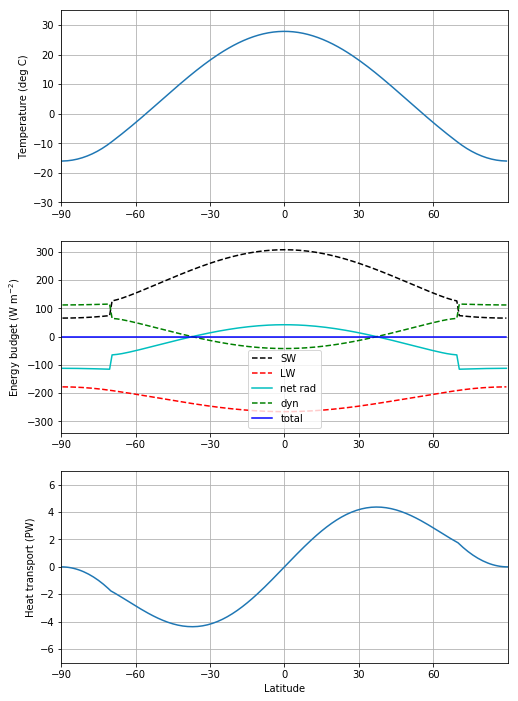

In [6]:
model1.integrate_years(5)
f = ebm_plot(model1)

In [7]:
model1.icelat

array([-70.,  70.])

____________
<a id='section2'></a>

## 2. Polar-amplified warming in the EBM
____________



### Add a small radiative forcing

The equivalent of doubling CO2 in this model is something like 

$$ A \rightarrow A - \delta A $$

where $\delta A = 4$ W m$^{-2}$.


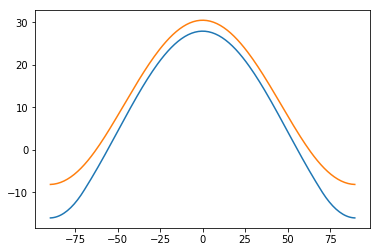

In [8]:
deltaA = 4.

model2 = climlab.process_like(model1)
model2.subprocess['LW'].A = param['A'] - deltaA
model2.integrate_years(5, verbose=False)

plt.plot(model1.lat, model1.Ts)
plt.plot(model2.lat, model2.Ts)

The warming is polar-amplified:  more warming at the poles than elsewhere.

Why?

Also, the current ice line is now:

In [9]:
model2.icelat

array([-90.,  90.])

There is no ice left!

Let's do some more greenhouse warming:

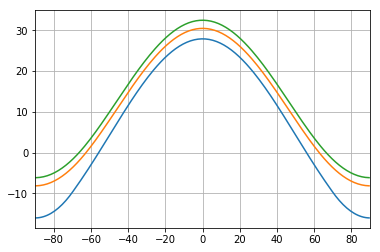

In [10]:
model3 = climlab.process_like(model1)
model3.subprocess['LW'].A = param['A'] - 2*deltaA
model3.integrate_years(5, verbose=False)

plt.plot(model1.lat, model1.Ts)
plt.plot(model2.lat, model2.Ts)
plt.plot(model3.lat, model3.Ts)
plt.xlim(-90, 90)
plt.grid()

In the ice-free regime, there is no polar-amplified warming. A uniform radiative forcing produces a uniform warming.

____________
<a id='section3'></a>

## 3. Effects of diffusivity in the annual mean EBM with albedo feedback
____________



### In-class investigation:

We will repeat the exercise from [Lecture 15](Lecture15 -- Diffusive energy balance model.ipynb), but this time with albedo feedback included in our model.

- Solve the annual-mean EBM (integrate out to equilibrium) over a range of different diffusivity parameters.
- Make three plots:
    - Global-mean temperature as a function of $D$
    - Equator-to-pole temperature difference $\Delta T$ as a function of $D$
    - Poleward heat transport across 35 degrees $\mathcal{H}_{max}$ as a function of $D$
- Choose a value of $D$ that gives a reasonable approximation to observations:
    - $\Delta T \approx 45$ ºC

Use these parameter values:

In [11]:
param = {'A':210, 'B':2, 'a0':0.3, 'a2':0.078, 'ai':0.62, 'Tf':-10.}
print( param)

{'A': 210, 'B': 2, 'a0': 0.3, 'a2': 0.078, 'ai': 0.62, 'Tf': -10.0}


### One possible way to do this:

In [12]:
Darray = np.arange(0., 2.05, 0.05)

In [13]:
model_list = []
Tmean_list = []
deltaT_list = []
Hmax_list = []
for D in Darray:
    ebm = climlab.EBM_annual(num_lat=360, D=D, **param )
    ebm.integrate_years(5., verbose=False)
    Tmean = ebm.global_mean_temperature()
    deltaT = np.max(ebm.Ts) - np.min(ebm.Ts)
    HT = ebm.heat_transport()
    ind = np.where(ebm.lat_bounds==35.5)[0]
    Hmax = HT[ind]
    model_list.append(ebm)
    Tmean_list.append(Tmean)
    deltaT_list.append(deltaT)
    Hmax_list.append(Hmax)

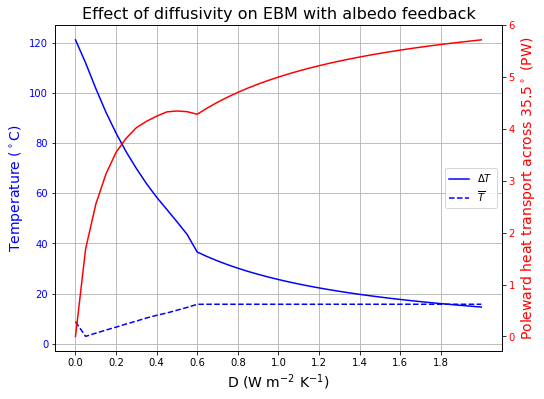

In [14]:
color1 = 'b'
color2 = 'r'

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.plot(Darray, deltaT_list, color=color1, label='$\Delta T$')
ax1.plot(Darray, Tmean_list, '--', color=color1, label='$\overline{T}$')
ax1.set_xlabel('D (W m$^{-2}$ K$^{-1}$)', fontsize=14)
ax1.set_xticks(np.arange(Darray[0], Darray[-1], 0.2))
ax1.set_ylabel('Temperature ($^\circ$C)', fontsize=14,  color=color1)
for tl in ax1.get_yticklabels():
    tl.set_color(color1)
ax1.legend(loc='center right')
ax2 = ax1.twinx()
ax2.plot(Darray, Hmax_list, color=color2)
ax2.set_ylabel('Poleward heat transport across 35.5$^\circ$ (PW)', fontsize=14, color=color2)
for tl in ax2.get_yticklabels():
    tl.set_color(color2)
ax1.set_title('Effect of diffusivity on EBM with albedo feedback', fontsize=16)
ax1.grid()

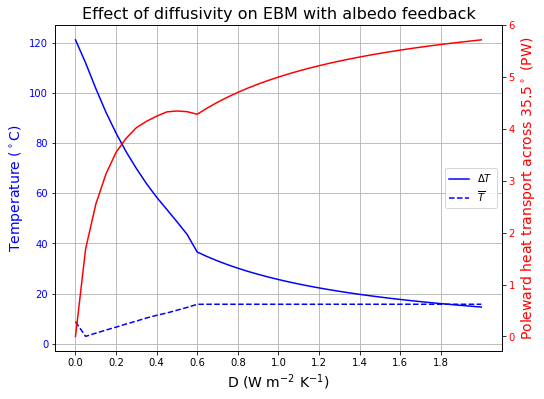

In [15]:
fig

____________
<a id='section4'></a>

## 4. Diffusive response to a point source of energy
____________

Let's add a point heat source to the EBM and see what sets the spatial structure of the response.

We will add a heat source at about 45º latitude.

First, we will calculate the response in a model **without albedo feedback**.

In [16]:
param_noalb = {'A': 210, 'B': 2, 'D': 0.55, 'Tf': -10.0, 'a0': 0.3, 'a2': 0.078}
m1 = climlab.EBM_annual(num_lat=180, **param_noalb)
print( m1)

climlab Process of type <class 'climlab.model.ebm.EBM_annual'>. 
State variables and domain shapes: 
  Ts: (180, 1) 
The subprocess tree: 
top: <class 'climlab.model.ebm.EBM_annual'>
   LW: <class 'climlab.radiation.aplusbt.AplusBT'>
   insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>
   albedo: <class 'climlab.surface.albedo.P2Albedo'>
   diffusion: <class 'climlab.dynamics.diffusion.MeridionalDiffusion'>



In [17]:
m1.integrate_years(5.)

Integrating for 450 steps, 1826.2110000000002 days, or 5.0 years.
Total elapsed time is 5.000000000000044 years.


In [18]:
m2 = climlab.process_like(m1)

In [19]:
point_source = climlab.process.energy_budget.ExternalEnergySource(state=m2.state)
ind = np.where(m2.lat == 45.5)
point_source.heating_rate['Ts'][ind] = 100.

m2.add_subprocess('point source', point_source)
print( m2)

climlab Process of type <class 'climlab.model.ebm.EBM_annual'>. 
State variables and domain shapes: 
  Ts: (180, 1) 
The subprocess tree: 
top: <class 'climlab.model.ebm.EBM_annual'>
   LW: <class 'climlab.radiation.aplusbt.AplusBT'>
   insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>
   albedo: <class 'climlab.surface.albedo.P2Albedo'>
   diffusion: <class 'climlab.dynamics.diffusion.MeridionalDiffusion'>
   point source: <class 'climlab.process.energy_budget.ExternalEnergySource'>



In [20]:
m2.integrate_years(5.)

Integrating for 450 steps, 1826.2110000000002 days, or 5.0 years.
Total elapsed time is 9.999999999999863 years.


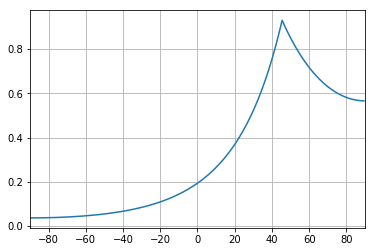

In [21]:
plt.plot(m2.lat, m2.Ts - m1.Ts)
plt.xlim(-90,90)
plt.grid()

The warming effects of our point source are felt **at all latitudes** but the effects decay away from the heat source.

Some analysis will show that the length scale of the warming is proportional to 

$$  \sqrt{\frac{D}{B}} $$

so increases with the diffusivity.

Now repeat this calculate **with ice albedo feedback**

In [22]:
m3 = climlab.EBM_annual(num_lat=180, **param)
m3.integrate_years(5.)
m4 = climlab.process_like(m3)
point_source = climlab.process.energy_budget.ExternalEnergySource(state=m4.state)
point_source.heating_rate['Ts'][ind] = 100.
m4.add_subprocess('point source', point_source)
m4.integrate_years(5.)

Integrating for 450 steps, 1826.2110000000002 days, or 5.0 years.
Total elapsed time is 5.000000000000044 years.
Integrating for 450 steps, 1826.2110000000002 days, or 5.0 years.
Total elapsed time is 9.999999999999863 years.


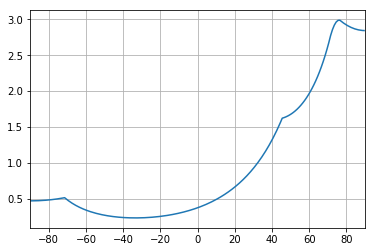

In [23]:
plt.plot(m4.lat, m4.Ts - m3.Ts)
plt.xlim(-90,90)
plt.grid()

Now the maximum warming **does not coincide with the heat source at 45º**!

Our heat source has led to melting of snow and ice, which induces an additional heat source in the high northern latitudes.

**Heat transport communicates the external warming to the ice cap, and also commuicates the increased shortwave absorption due to ice melt globally!**

<div class="alert alert-success">
[Back to ATM 623 notebook home](../index.ipynb)
</div>

____________
## Version information
____________


In [24]:
%load_ext version_information
%version_information numpy, matplotlib, climlab

Loading extensions from ~/.ipython/extensions is deprecated. We recommend managing extensions like any other Python packages, in site-packages.


Software versions
Python 3.6.2 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 6.1.0
OS Darwin 16.7.0 x86_64 i386 64bit
numpy 1.13.1
matplotlib 2.0.2
climlab 0.6.0.dev10
Wed Oct 11 13:47:30 2017 EDT

____________

## Credits

The author of this notebook is [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

It was developed in support of [ATM 623: Climate Modeling](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/), a graduate-level course in the [Department of Atmospheric and Envionmental Sciences](http://www.albany.edu/atmos/index.php)

Development of these notes and the [climlab software](https://github.com/brian-rose/climlab) is partially supported by the National Science Foundation under award AGS-1455071 to Brian Rose. Any opinions, findings, conclusions or recommendations expressed here are mine and do not necessarily reflect the views of the National Science Foundation.
____________